<a href="https://colab.research.google.com/github/UjwalNagrikar/Quant-Trade-Model/blob/main/Quant_Trading_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

New Model test

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BTC-USD']: YFPricesMissingError('possibly delisted; no price data found  (period=1d) (Yahoo error = "Invalid input - interval=20m is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 4h, 1d, 5d, 1wk, 1mo, 3mo]")')



🚀 ADVANCED TRADING STRATEGY BACKTESTER
   McGinley Dynamic + RSI + MACD + Bollinger Bands

📥 Downloading BTC-USD data...
   Interval: 20m, Period: 1d
⚠️  No data downloaded. Using synthetic data.
🔧 Generating 5000 bars of synthetic data...
✓ Generated 5000 bars


🚀 STARTING ADVANCED BACKTEST
Initial Capital: ₹500,000.00
Risk per Trade: 10%
Data Period: 2024-01-01 00:00:00 to 2024-07-27 07:00:00
Total Bars: 5000

📊 Calculating indicators...
✓ Indicators calculated

🔄 Running backtest...


🔔 LONG Entry @ ₹52264.00
  Quantity: 7.1751 | Value: ₹375,000
  Stop Loss: ₹47037.60 (10%) | Take Profit: ₹58535.68 (12%)
✅ Time Stop: LONG | ₹53807.47 | P&L: ₹11,075 (3.0%)

🔔 LONG Entry @ ₹54273.85
  Quantity: 7.0624 | Value: ₹383,306
  Stop Loss: ₹48846.47 (10%) | Take Profit: ₹60786.72 (12%)
  ✓ Partial exit (50%) at 6.6% profit
  → Trailing stop activated at 8.5% profit
✅ Take Profit: LONG | ₹61059.36 | P&L: ₹23,961 (6.3%)

🔔 LONG Entry @ ₹61291.02
  Quantity: 6.7015 | Value: ₹410,741
  Stop Loss

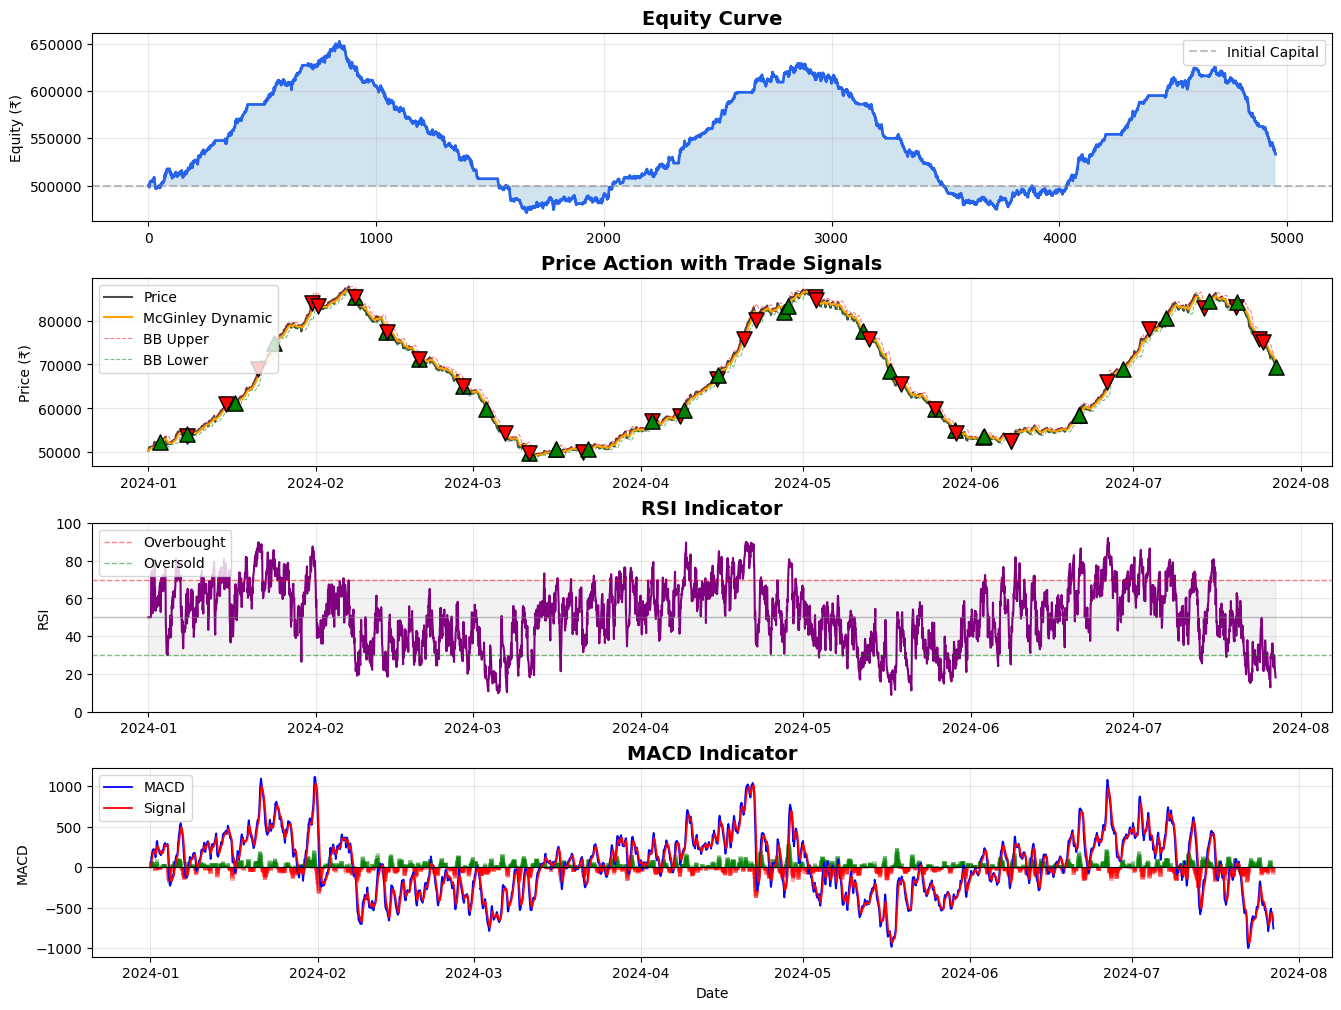

✅ BACKTEST COMPLETE!



In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class AdvancedTradingStrategy:
    def __init__(self, initial_capital=500000, risk_per_trade=0.10):
        """
        Enhanced trading strategy with improved accuracy

        Args:
            initial_capital: Starting capital in INR
            risk_per_trade: Risk percentage per trade (default 10%)
        """
        self.initial_capital = initial_capital
        self.risk_per_trade = risk_per_trade
        self.capital = initial_capital
        self.position = None
        self.trades = []
        self.equity_curve = []

    def calculate_mcginley_dynamic(self, prices, period=14, constant=0.6):
        """Calculate McGinley Dynamic - adaptive moving average"""
        md = pd.Series(index=prices.index, dtype=float)
        md.iloc[0] = prices.iloc[0]

        for i in range(1, len(prices)):
            prev_md = md.iloc[i-1]
            price = prices.iloc[i]

            if prev_md == 0 or pd.isna(prev_md):
                md.iloc[i] = price
                continue

            ratio = max(0.5, min(price / prev_md, 2.0))
            n = max(period * (ratio ** 4) * constant, 1.0)
            md.iloc[i] = prev_md + (price - prev_md) / n

        return md

    def calculate_rsi(self, prices, period=14):
        """Calculate RSI with Wilder's smoothing"""
        delta = prices.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi.fillna(50)

    def calculate_macd(self, prices, fast=12, slow=26, signal=9):
        """Calculate MACD indicator"""
        ema_fast = prices.ewm(span=fast, adjust=False).mean()
        ema_slow = prices.ewm(span=slow, adjust=False).mean()
        macd_line = ema_fast - ema_slow
        signal_line = macd_line.ewm(span=signal, adjust=False).mean()
        histogram = macd_line - signal_line
        return macd_line, signal_line, histogram

    def calculate_atr(self, high, low, close, period=14):
        """Calculate Average True Range"""
        high_low = high - low
        high_close = np.abs(high - close.shift())
        low_close = np.abs(low - close.shift())

        ranges = pd.concat([high_low, high_close, low_close], axis=1)
        true_range = ranges.max(axis=1)
        atr = true_range.ewm(span=period, adjust=False).mean()
        return atr

    def calculate_bollinger_bands(self, prices, period=20, std_dev=2):
        """Calculate Bollinger Bands"""
        sma = prices.rolling(window=period).mean()
        std = prices.rolling(window=period).std()
        upper_band = sma + (std * std_dev)
        lower_band = sma - (std * std_dev)
        return upper_band, sma, lower_band

    def calculate_trend_strength(self, close, md, period=20):
        """Calculate trend strength (0-1 scale)"""
        price_above_md = (close > md).astype(int)
        trend_strength = price_above_md.rolling(window=period).mean()
        return trend_strength

    def calculate_volume_profile(self, volume, period=20):
        """Calculate volume trend"""
        vol_ma = volume.rolling(window=period).mean()
        vol_ratio = volume / vol_ma
        return vol_ratio

    def calculate_momentum(self, prices, period=10):
        """Calculate price momentum"""
        momentum = prices.diff(period) / prices.shift(period) * 100
        return momentum

    def is_liquid_hour(self, timestamp):
        """Check if trading during high liquidity hours"""
        hour = timestamp.hour
        return 0 <= hour <= 10  # Extended for crypto markets

    def check_long_signal(self, i, close, md, rsi, macd_hist, macd_line,
                         trend_strength, bb_upper, bb_lower, momentum):
        """
        Enhanced long entry signal - balanced conditions

        Requirements (relaxed for better signal generation):
        1. Price crosses above McGinley Dynamic OR price above MD with momentum
        2. RSI > 45 (bullish territory)
        3. MACD bullish (crossover OR already positive with upward momentum)
        4. Basic trend confirmation
        """
        if i < 3:
            return False

        # Core Signal 1: Price position relative to MD
        price_above_md = close.iloc[i] > md.iloc[i]
        price_cross = (close.iloc[i-1] <= md.iloc[i-1] and
                      close.iloc[i] > md.iloc[i])
        # Accept if crossing OR already above with momentum
        price_signal = price_cross or (price_above_md and close.iloc[i] > close.iloc[i-1])

        # Core Signal 2: RSI in bullish zone (relaxed from 50-75 to 45-80)
        rsi_valid = 45 < rsi.iloc[i] < 80

        # Core Signal 3: MACD bullish (crossover OR positive with momentum)
        macd_cross = (macd_hist.iloc[i] > 0 and macd_hist.iloc[i-1] <= 0)
        macd_positive = macd_hist.iloc[i] > 0 and macd_line.iloc[i] > macd_line.iloc[i-1]
        macd_signal = macd_cross or macd_positive

        # Confirmation 1: Not in extreme overbought (relaxed)
        not_extreme = rsi.iloc[i] < 78

        # Confirmation 2: Some positive momentum
        has_momentum = close.iloc[i] > close.iloc[i-2] or momentum.iloc[i] > -1

        # Confirmation 3: Trend direction (relaxed)
        trend_ok = (trend_strength.iloc[i] > 0.3 if
                   not pd.isna(trend_strength.iloc[i]) else True)

        # Combine conditions (more lenient)
        core_signals = price_signal and rsi_valid and macd_signal
        confirmations = not_extreme and has_momentum and trend_ok

        return core_signals and confirmations

    def check_short_signal(self, i, close, md, rsi, macd_hist, macd_line,
                          trend_strength, bb_upper, bb_lower, momentum):
        """
        Enhanced short entry signal - balanced conditions

        Requirements (relaxed for better signal generation):
        1. Price crosses below McGinley Dynamic OR price below MD with momentum
        2. RSI < 55 (bearish territory)
        3. MACD bearish (crossover OR already negative with downward momentum)
        4. Basic trend confirmation
        """
        if i < 3:
            return False

        # Core Signal 1: Price position relative to MD
        price_below_md = close.iloc[i] < md.iloc[i]
        price_cross = (close.iloc[i-1] >= md.iloc[i-1] and
                      close.iloc[i] < md.iloc[i])
        # Accept if crossing OR already below with momentum
        price_signal = price_cross or (price_below_md and close.iloc[i] < close.iloc[i-1])

        # Core Signal 2: RSI in bearish zone (relaxed from 25-50 to 20-55)
        rsi_valid = 20 < rsi.iloc[i] < 55

        # Core Signal 3: MACD bearish (crossover OR negative with momentum)
        macd_cross = (macd_hist.iloc[i] < 0 and macd_hist.iloc[i-1] >= 0)
        macd_negative = macd_hist.iloc[i] < 0 and macd_line.iloc[i] < macd_line.iloc[i-1]
        macd_signal = macd_cross or macd_negative

        # Confirmation 1: Not in extreme oversold (relaxed)
        not_extreme = rsi.iloc[i] > 22

        # Confirmation 2: Some negative momentum
        has_momentum = close.iloc[i] < close.iloc[i-2] or momentum.iloc[i] < 1

        # Confirmation 3: Trend direction (relaxed)
        trend_ok = (trend_strength.iloc[i] < 0.7 if
                   not pd.isna(trend_strength.iloc[i]) else True)

        # Combine conditions (more lenient)
        core_signals = price_signal and rsi_valid and macd_signal
        confirmations = not_extreme and has_momentum and trend_ok

        return core_signals and confirmations

    def calculate_position_size(self, price, atr, volatility_pct=None):
        """
        Dynamic position sizing based on volatility and risk management

        Args:
            price: Current price
            atr: Average True Range
            volatility_pct: Volatility percentile (0-1)
        """
        # Base risk amount
        risk_amount = self.capital * self.risk_per_trade

        # Calculate base position size (10% stop loss)
        stop_loss_pct = 0.10
        position_size = risk_amount / (price * stop_loss_pct)

        # Adjust for ATR-based volatility
        if not np.isnan(atr):
            atr_pct = (atr / price) * 100

            if atr_pct > 3.5:  # Very high volatility
                position_size *= 0.5
            elif atr_pct > 2.5:  # High volatility
                position_size *= 0.65
            elif atr_pct > 1.5:  # Medium volatility
                position_size *= 0.8
            # Low volatility: keep full size

        # Maximum 75% of capital (conservative)
        max_position = (self.capital * 0.75) / price
        position_size = min(position_size, max_position)

        # Minimum 5% of capital
        min_position = (self.capital * 0.05) / price
        position_size = max(position_size, min_position)

        return position_size

    def calculate_dynamic_stops(self, entry_price, atr, position_type):
        """Calculate fixed stop loss and take profit"""
        # Fixed 12% take profit
        tp_pct = 0.12

        # Stop loss between 10-12% based on volatility
        if pd.isna(atr):
            sl_pct = 0.10
        else:
            atr_distance = atr / entry_price
            # If high volatility, use wider stop (up to 12%)
            if atr_distance > 0.03:
                sl_pct = 0.12
            elif atr_distance > 0.02:
                sl_pct = 0.11
            else:
                sl_pct = 0.10

        if position_type == 'LONG':
            stop_loss = entry_price * (1 - sl_pct)
            take_profit = entry_price * (1 + tp_pct)
        else:
            stop_loss = entry_price * (1 + sl_pct)
            take_profit = entry_price * (1 - tp_pct)

        return stop_loss, take_profit, sl_pct, tp_pct

    def check_exit_conditions(self, i, close, md, rsi):
        """
        Enhanced exit logic with trailing stop
        """
        current_price = close.iloc[i]
        entry_price = self.position['entry']

        # Calculate P&L
        if self.position['type'] == 'LONG':
            pnl_pct = (current_price - entry_price) / entry_price
        else:
            pnl_pct = (entry_price - current_price) / entry_price

        # Activate trailing stop at 8% profit
        if pnl_pct > 0.08 and not self.position.get('trailing_active'):
            self.position['trailing_active'] = True
            self.position['highest_price'] = current_price
            print(f"  → Trailing stop activated at {pnl_pct*100:.1f}% profit")

        # Update trailing stop
        if self.position.get('trailing_active'):
            if self.position['type'] == 'LONG':
                if current_price > self.position['highest_price']:
                    self.position['highest_price'] = current_price
                    # Lock in 50% of profit
                    self.position['trailing_stop'] = (
                        entry_price + (current_price - entry_price) * 0.5
                    )
            else:
                if current_price < self.position['highest_price']:
                    self.position['highest_price'] = current_price
                    self.position['trailing_stop'] = (
                        entry_price - (entry_price - current_price) * 0.5
                    )

        # Partial exit at 6% profit
        if not self.position.get('partial_exited') and pnl_pct >= 0.06:
            exit_qty = self.position['quantity'] * 0.5
            exit_value = exit_qty * current_price
            self.capital += exit_value
            self.position['quantity'] -= exit_qty
            self.position['partial_exited'] = True

            # Move stop to breakeven
            self.position['stop_loss'] = entry_price

            print(f"  ✓ Partial exit (50%) at {pnl_pct*100:.1f}% profit")

        # Check exit conditions
        exit_reason = None

        # 1. Trailing stop
        if self.position.get('trailing_active'):
            ts = self.position.get('trailing_stop', 0)
            if ((self.position['type'] == 'LONG' and current_price < ts) or
                (self.position['type'] == 'SHORT' and current_price > ts)):
                exit_reason = 'Trailing Stop'

        # 2. Stop loss and take profit
        if not exit_reason:
            sl_pct = self.position.get('sl_pct', 0.10)
            tp_pct = self.position.get('tp_pct', 0.15)

            if pnl_pct >= tp_pct:
                exit_reason = 'Take Profit'
            elif pnl_pct <= -sl_pct:
                exit_reason = 'Stop Loss'

        # 3. Time-based exit (prevent dead trades)
        bars_held = i - self.position.get('entry_bar', i)
        if bars_held > 120 and abs(pnl_pct) < 0.03:
            exit_reason = 'Time Stop'

        # 4. Signal reversal (strong opposite signal)
        if not exit_reason:
            if self.position['type'] == 'LONG':
                if close.iloc[i] < md.iloc[i] * 0.97 and rsi.iloc[i] < 40:
                    exit_reason = 'Signal Reversal'
            else:
                if close.iloc[i] > md.iloc[i] * 1.03 and rsi.iloc[i] > 60:
                    exit_reason = 'Signal Reversal'

        return exit_reason

    def execute_exit(self, i, close, timestamp, exit_reason):
        """Execute exit with P&L calculation"""
        current_price = close.iloc[i]
        exit_value = self.position['quantity'] * current_price
        self.capital += exit_value

        # Calculate P&L
        original_qty = self.position.get('original_quantity', self.position['quantity'])
        if self.position['type'] == 'LONG':
            pnl = exit_value - (self.position['quantity'] * self.position['entry'])
        else:
            pnl = (self.position['quantity'] * self.position['entry']) - exit_value

        pnl_pct = (pnl / (original_qty * self.position['entry'])) * 100

        # Record trade
        trade = {
            'type': self.position['type'],
            'entry': self.position['entry'],
            'entry_time': self.position['entry_time'],
            'exit': current_price,
            'exit_time': timestamp,
            'quantity': self.position['quantity'],
            'pnl': pnl,
            'pnl_pct': pnl_pct,
            'exit_reason': exit_reason,
            'bars_held': i - self.position.get('entry_bar', i)
        }

        self.trades.append(trade)

        emoji = "✅" if pnl > 0 else "❌"
        print(f"{emoji} {exit_reason}: {self.position['type']} | "
              f"₹{current_price:.2f} | P&L: ₹{pnl:,.0f} ({pnl_pct:.1f}%)")

        self.position = None

    def execute_entry(self, i, close, timestamp, signal_type, position_size, atr):
        """Execute entry trade"""
        entry_price = close.iloc[i]
        position_value = position_size * entry_price

        if position_value <= self.capital * 0.95:
            sl, tp, sl_pct, tp_pct = self.calculate_dynamic_stops(
                entry_price, atr, signal_type
            )

            self.position = {
                'type': signal_type,
                'entry': entry_price,
                'entry_time': timestamp,
                'entry_bar': i,
                'quantity': position_size,
                'original_quantity': position_size,
                'partial_exited': False,
                'trailing_active': False,
                'stop_loss': sl,
                'take_profit': tp,
                'sl_pct': sl_pct,
                'tp_pct': tp_pct
            }

            self.capital -= position_value

            print(f"\n🔔 {signal_type} Entry @ ₹{entry_price:.2f}")
            print(f"  Quantity: {position_size:.4f} | Value: ₹{position_value:,.0f}")
            print(f"  Stop Loss: ₹{sl:.2f} ({sl_pct*100:.0f}%) | Take Profit: ₹{tp:.2f} (12%)")

    def backtest(self, data):
        """Run complete backtest"""
        print(f"\n{'='*80}")
        print(f"🚀 STARTING ADVANCED BACKTEST")
        print(f"{'='*80}")
        print(f"Initial Capital: ₹{self.initial_capital:,.2f}")
        print(f"Risk per Trade: {self.risk_per_trade*100:.0f}%")
        print(f"Data Period: {data.index[0]} to {data.index[-1]}")
        print(f"Total Bars: {len(data)}")
        print(f"{'='*80}\n")

        # Calculate all indicators
        close = data['Close']
        high = data['High']
        low = data['Low']
        volume = data['Volume']

        print("📊 Calculating indicators...")
        md = self.calculate_mcginley_dynamic(close)
        rsi = self.calculate_rsi(close)
        macd_line, signal_line, macd_hist = self.calculate_macd(close)
        atr = self.calculate_atr(high, low, close)
        bb_upper, bb_mid, bb_lower = self.calculate_bollinger_bands(close)
        trend_strength = self.calculate_trend_strength(close, md)
        momentum = self.calculate_momentum(close)

        # Add to dataframe
        data['MD'] = md
        data['RSI'] = rsi
        data['MACD_Line'] = macd_line
        data['MACD_Signal'] = signal_line
        data['MACD_Hist'] = macd_hist
        data['ATR'] = atr
        data['BB_Upper'] = bb_upper
        data['BB_Lower'] = bb_lower
        data['Trend_Strength'] = trend_strength
        data['Momentum'] = momentum

        print("✓ Indicators calculated\n")
        print("🔄 Running backtest...\n")

        # Backtest loop
        for i in range(50, len(data)):
            timestamp = data.index[i]

            # Time filter
            if not self.is_liquid_hour(timestamp):
                equity = self.capital + (
                    self.position['quantity'] * close.iloc[i]
                    if self.position else 0
                )
                self.equity_curve.append(equity)
                continue

            # Exit management
            if self.position:
                exit_reason = self.check_exit_conditions(i, close, md, rsi)
                if exit_reason:
                    self.execute_exit(i, close, timestamp, exit_reason)

            # Entry signals
            if not self.position:
                position_size = self.calculate_position_size(
                    close.iloc[i], atr.iloc[i]
                )

                # Check long
                if self.check_long_signal(i, close, md, rsi, macd_hist,
                                         macd_line, trend_strength,
                                         bb_upper, bb_lower, momentum):
                    self.execute_entry(i, close, timestamp, 'LONG',
                                     position_size, atr.iloc[i])

                # Check short
                elif self.check_short_signal(i, close, md, rsi, macd_hist,
                                            macd_line, trend_strength,
                                            bb_upper, bb_lower, momentum):
                    self.execute_entry(i, close, timestamp, 'SHORT',
                                     position_size, atr.iloc[i])

            # Record equity
            equity = self.capital + (
                self.position['quantity'] * close.iloc[i]
                if self.position else 0
            )
            self.equity_curve.append(equity)

        # Close final position
        if self.position:
            self.execute_exit(len(data)-1, close, data.index[-1], 'End of Backtest')

        print(f"\n{'='*80}")
        print("✓ Backtest completed")
        print(f"{'='*80}\n")

        return self.generate_results()

    def generate_results(self):
        """Generate comprehensive statistics"""
        if not self.trades:
            print("⚠️  No trades executed")
            return None

        trades_df = pd.DataFrame(self.trades)

        # Performance metrics
        total_return = ((self.capital - self.initial_capital) /
                       self.initial_capital) * 100

        winning_trades = trades_df[trades_df['pnl'] > 0]
        losing_trades = trades_df[trades_df['pnl'] <= 0]

        win_rate = len(winning_trades) / len(trades_df) * 100
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = abs(losing_trades['pnl'].mean()) if len(losing_trades) > 0 else 0
        profit_factor = avg_win / avg_loss if avg_loss > 0 else 0

        # Risk metrics
        equity_series = pd.Series(self.equity_curve)
        rolling_max = equity_series.expanding().max()
        drawdown = (equity_series - rolling_max) / rolling_max * 100
        max_drawdown = abs(drawdown.min())

        # Sharpe ratio (annualized for hourly data)
        returns = equity_series.pct_change().dropna()
        sharpe = ((returns.mean() / returns.std()) * np.sqrt(252 * 24)
                 if returns.std() > 0 else 0)

        # Additional metrics
        total_long = len(trades_df[trades_df['type'] == 'LONG'])
        total_short = len(trades_df[trades_df['type'] == 'SHORT'])
        avg_bars = trades_df['bars_held'].mean()

        # Consecutive wins/losses
        win_streak = 0
        loss_streak = 0
        current_streak = 0
        for pnl in trades_df['pnl']:
            if pnl > 0:
                current_streak = current_streak + 1 if current_streak > 0 else 1
                win_streak = max(win_streak, current_streak)
            else:
                current_streak = current_streak - 1 if current_streak < 0 else -1
                loss_streak = max(loss_streak, abs(current_streak))

        return {
            'initial_capital': self.initial_capital,
            'final_capital': self.capital,
            'total_return': total_return,
            'total_trades': len(trades_df),
            'winning_trades': len(winning_trades),
            'losing_trades': len(losing_trades),
            'win_rate': win_rate,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'profit_factor': profit_factor,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe,
            'total_long': total_long,
            'total_short': total_short,
            'avg_bars_held': avg_bars,
            'max_win_streak': win_streak,
            'max_loss_streak': loss_streak,
            'trades_df': trades_df,
            'equity_curve': self.equity_curve
        }

    def print_results(self, results):
        """Print formatted results"""
        if not results:
            return

        print(f"{'='*80}")
        print("📈 BACKTEST RESULTS")
        print(f"{'='*80}\n")

        print("💰 CAPITAL PERFORMANCE")
        print(f"  Initial Capital:     ₹{results['initial_capital']:>12,.0f}")
        print(f"  Final Capital:       ₹{results['final_capital']:>12,.0f}")
        print(f"  Total Return:        {results['total_return']:>12.2f}%")
        print(f"  Max Drawdown:        {results['max_drawdown']:>12.2f}%")
        print(f"  Sharpe Ratio:        {results['sharpe_ratio']:>12.2f}")

        print(f"\n📊 TRADE STATISTICS")
        print(f"  Total Trades:        {results['total_trades']:>12}")
        print(f"  Long Trades:         {results['total_long']:>12}")
        print(f"  Short Trades:        {results['total_short']:>12}")
        print(f"  Winning Trades:      {results['winning_trades']:>12}")
        print(f"  Losing Trades:       {results['losing_trades']:>12}")
        print(f"  Win Rate:            {results['win_rate']:>12.1f}%")
        print(f"  Avg Bars Held:       {results['avg_bars_held']:>12.1f}")

        print(f"\n💵 PROFITABILITY")
        print(f"  Average Win:         ₹{results['avg_win']:>12,.0f}")
        print(f"  Average Loss:        ₹{results['avg_loss']:>12,.0f}")
        print(f"  Profit Factor:       {results['profit_factor']:>12.2f}")
        print(f"  Max Win Streak:      {results['max_win_streak']:>12}")
        print(f"  Max Loss Streak:     {results['max_loss_streak']:>12}")

        print(f"\n{'='*80}")
        print("📋 LAST 10 TRADES")
        print(f"{'='*80}\n")

        for idx, trade in results['trades_df'].tail(10).iterrows():
            emoji = "✅" if trade['pnl'] > 0 else "❌"
            print(f"{emoji} {trade['type']:5} | Entry: ₹{trade['entry']:8.2f} | "
                  f"Exit: ₹{trade['exit']:8.2f} | P&L: {trade['pnl_pct']:6.1f}% | "
                  f"{trade['exit_reason']}")

        print(f"\n{'='*80}\n")

    def plot_results(self, results, data):
        """Create comprehensive visualization"""
        if not results:
            return

        fig = plt.figure(figsize=(16, 12))
        gs = fig.add_gridspec(4, 1, hspace=0.3)

        # 1. Equity Curve
        ax1 = fig.add_subplot(gs[0])
        equity = results['equity_curve']
        ax1.plot(equity, linewidth=2, color='#2563eb')
        ax1.axhline(self.initial_capital, color='gray',
                   linestyle='--', alpha=0.5, label='Initial Capital')
        ax1.fill_between(range(len(equity)), equity,
                        self.initial_capital, alpha=0.2)
        ax1.set_title('Equity Curve', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Equity (₹)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Price with trades
        ax2 = fig.add_subplot(gs[1])
        ax2.plot(data.index, data['Close'], label='Price',
                linewidth=1.5, color='black', alpha=0.7)
        ax2.plot(data.index, data['MD'], label='McGinley Dynamic',
                linewidth=1.5, color='orange')
        ax2.plot(data.index, data['BB_Upper'], label='BB Upper',
                linewidth=0.8, color='red', alpha=0.5, linestyle='--')
        ax2.plot(data.index, data['BB_Lower'], label='BB Lower',
                linewidth=0.8, color='green', alpha=0.5, linestyle='--')

        # Plot trade signals
        for trade in results['trades_df'].itertuples():
            if trade.type == 'LONG':
                ax2.scatter(trade.entry_time, trade.entry, color='green',
                          marker='^', s=120, zorder=5, edgecolors='black', linewidths=1)
                ax2.scatter(trade.exit_time, trade.exit, color='red',
                          marker='v', s=120, zorder=5, edgecolors='black', linewidths=1)
            else:
                ax2.scatter(trade.entry_time, trade.entry, color='red',
                          marker='v', s=120, zorder=5, edgecolors='black', linewidths=1)
                ax2.scatter(trade.exit_time, trade.exit, color='green',
                          marker='^', s=120, zorder=5, edgecolors='black', linewidths=1)

        ax2.set_title('Price Action with Trade Signals', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Price (₹)')
        ax2.legend(loc='upper left')
        ax2.grid(True, alpha=0.3)

        # 3. RSI
        ax3 = fig.add_subplot(gs[2])
        ax3.plot(data.index, data['RSI'], linewidth=1.5, color='purple')
        ax3.axhline(50, color='gray', linestyle='-', linewidth=1, alpha=0.5)
        ax3.axhline(70, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Overbought')
        ax3.axhline(30, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Oversold')
        ax3.fill_between(data.index, 30, 70, alpha=0.1, color='gray')
        ax3.set_title('RSI Indicator', fontsize=14, fontweight='bold')
        ax3.set_ylabel('RSI')
        ax3.set_ylim([0, 100])
        ax3.legend(loc='upper left')
        ax3.grid(True, alpha=0.3)

        # 4. MACD
        ax4 = fig.add_subplot(gs[3])
        ax4.plot(data.index, data['MACD_Line'], label='MACD',
                linewidth=1.3, color='blue')
        ax4.plot(data.index, data['MACD_Signal'], label='Signal',
                linewidth=1.3, color='red')

        # MACD histogram
        colors = ['green' if x > 0 else 'red' for x in data['MACD_Hist']]
        ax4.bar(data.index, data['MACD_Hist'], alpha=0.3, color=colors, width=0.8)
        ax4.axhline(0, color='black', linestyle='-', linewidth=0.8)
        ax4.set_title('MACD Indicator', fontsize=14, fontweight='bold')
        ax4.set_ylabel('MACD')
        ax4.set_xlabel('Date')
        ax4.legend(loc='upper left')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('backtest_results.png', dpi=300, bbox_inches='tight')
        print("📊 Chart saved as 'backtest_results.png'")
        plt.show()


def download_data(ticker='BTC-USD', interval='1h', period='60d'):
    """Download historical data from Yahoo Finance"""
    print(f"\n📥 Downloading {ticker} data...")
    print(f"   Interval: {interval}, Period: {period}")

    try:
        data = yf.download(ticker, interval=interval, period=period, progress=False)

        if data.empty:
            print("⚠️  No data downloaded. Using synthetic data.")
            return generate_synthetic_data()

        # Handle MultiIndex columns
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = [col[0] if isinstance(col, tuple) else col
                          for col in data.columns]

        # Verify required columns
        required = ['Close', 'High', 'Low', 'Open', 'Volume']
        for col in required:
            if col not in data.columns:
                raise ValueError(f"Missing column: {col}")

        data = data[required]
        print(f"✓ Downloaded {len(data)} bars\n")
        return data

    except Exception as e:
        print(f"❌ Error: {e}")
        print("⚠️  Using synthetic data instead.\n")
        return generate_synthetic_data()


def generate_synthetic_data(bars=5000):
    """Generate synthetic price data for testing"""
    print(f"🔧 Generating {bars} bars of synthetic data...")

    dates = pd.date_range(start='2024-01-01', periods=bars, freq='1h')
    price = 50000

    data_list = []
    for i, date in enumerate(dates):
        hour = date.hour

        # Simulate volatility
        volatility = 0.004 if (0 <= hour <= 10) else 0.002
        trend = np.sin(i / 300) * 0.0008
        change = np.random.randn() * volatility + trend

        price = price * (1 + change)
        high = price * (1 + abs(np.random.randn()) * 0.003)
        low = price * (1 - abs(np.random.randn()) * 0.003)
        open_price = price * (1 + np.random.randn() * 0.002)
        volume = np.random.uniform(1000000, 3000000)

        data_list.append({
            'Open': open_price,
            'High': high,
            'Low': low,
            'Close': price,
            'Volume': volume
        })

    df = pd.DataFrame(data_list, index=dates)
    print(f"✓ Generated {len(df)} bars\n")
    return df


if __name__ == "__main__":
    print("\n" + "="*80)
    print("🚀 ADVANCED TRADING STRATEGY BACKTESTER")
    print("   McGinley Dynamic + RSI + MACD + Bollinger Bands")
    print("="*80)

    # Download data
    # Options:
    # - Crypto: 'BTC-USD', 'ETH-USD'
    # - US Stocks: 'AAPL', 'TSLA', 'GOOGL'
    # - Indian Stocks: 'RELIANCE.NS', 'TCS.NS', 'INFY.NS'

    data = download_data(ticker='BTC-USD', interval='20m', period='1d')

    # Or use synthetic data:
    # data = generate_synthetic_data(5000)

    # Initialize strategy
    strategy = AdvancedTradingStrategy(
        initial_capital=500000,  # ₹5 lakhs
        risk_per_trade=0.10      # 10% risk per trade
    )

    # Run backtest
    results = strategy.backtest(data)

    # Print results
    strategy.print_results(results)

    # Plot results
    if results:
        strategy.plot_results(results, data)

    print(f"{'='*80}")
    print("✅ BACKTEST COMPLETE!")
    print(f"{'='*80}\n")